In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
data  = pd.read_csv('/home/jupyter-n.sobolevskaja-14/Stat/hw_aa.csv', sep=";")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter-n.sobolevskaja-14/Stat/hw_aa.csv'

In [3]:
# смотрим на данные: по типам, в разрезе колонок, пропущенным значениям
data.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [4]:
data.shape

(127018, 5)

In [5]:
data.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [6]:
data.isna().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [7]:
data.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [8]:
data.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [9]:
data.purchase.value_counts()

0    122104
1      4914
Name: purchase, dtype: int64

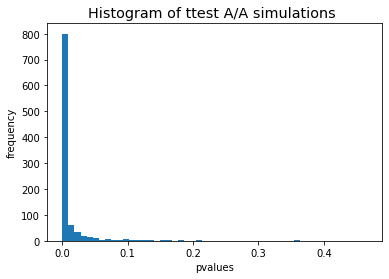

0.933

In [10]:
# проводим А/А тестерирование для всех данных по группам тест/контроль
# в результате FPR > α, следовательно сплитовалка работает некорректно

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = data[data.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    s2 = data[data.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

In [11]:
# делаем группировку по версиям МП: считаем сумму покупок по каждой версии и размер выборок
# видно, что выборки по каждой версии достаточно равномерны (count)
# а вот в количестве покупок в версии v2.8.0 есть явный перекос между группами

data_2 = data.groupby(['version','experimentVariant'], as_index=False) \
    .agg({'purchase':'sum', 'Unnamed: 0':'count'}) \
    .rename(columns = {'Unnamed: 0':'count'})
data_2

,version,experimentVariant,purchase,count
0,v2.8.0,0,41,41283
1,v2.8.0,1,1895,41552
2,v2.9.0,0,890,11921
3,v2.9.0,1,858,12033
4,v3.7.4.0,0,252,4204
5,v3.7.4.0,1,266,4221
6,v3.8.0.0,0,328,5694
7,v3.8.0.0,1,384,6110


In [12]:
# считаем конверсию для каждй версии и полученные значения подверждают предыдущие выводы
# что-то в версии v2.8.0 работает некорректно: конверсии в покупку тестовой и конрольной
# групп слишком сильно отличаются друг от друга

data_2['conversion'] = data_2['purchase'] / data_2['count'] * 100

In [13]:
data_2

,version,experimentVariant,purchase,count,conversion
0,v2.8.0,0,41,41283,0.099314
1,v2.8.0,1,1895,41552,4.560551
2,v2.9.0,0,890,11921,7.465817
3,v2.9.0,1,858,12033,7.130391
4,v3.7.4.0,0,252,4204,5.994291
5,v3.7.4.0,1,266,4221,6.301824
6,v3.8.0.0,0,328,5694,5.760450
7,v3.8.0.0,1,384,6110,6.284779


In [14]:
# исключим эту версию приложения из первоначального датасета

data_3 = data.query('version != "v2.8.0"')
data_3.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
6,7,8f14e45fceea167a5a36dedd4bea2543,0,v2.9.0,0
10,11,6512bd43d9caa6e02c990b0a82652dca,1,v2.9.0,0
13,14,aab3238922bcc25a6f606eb525ffdc56,1,v2.9.0,0


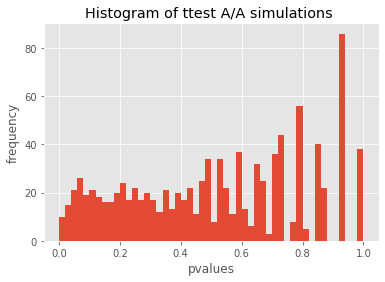

0.035

In [15]:
# проводим А/А тестерирование для датасета с исклюеченной версией
# в результате FPR < α, следовательно сплитовалка для оставшихся версий работает корректно

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = data_3[data_3.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    s2 = data_3[data_3.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations